Training on Parameter subspaces

Importing libraries

In [ ]:
import torch
from torch import nn
import math
from math import sqrt
import time
from sympy import fwht
import random
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader
import scipy
import numpy as np
from scipy.linalg import orth
import torchvision
import torchvision.transforms as transforms

Defining functions

In [ ]:
def dense_matrix (D,d): #this returns a dense projection matrix
  mat = torch.rand(D,d)
  mat = torch.nn.functional.normalize(mat, p=2.0, dim = 0)
  return mat

In [ ]:
def sparse_matrix(D,d): #this returns a sparse projection matrix. The other kinds of projection matrices will be defined later
  mat = torch.rand(D,d)
  mat = torch.nn.functional.normalize(mat, p=2.0, dim = 0)
  non_zero_prob = 1/math.sqrt(D)
  mat = mat/non_zero_prob
  mat = torch.nn.functional.dropout(mat, p=(1-non_zero_prob)).to_sparse()
  return mat

In [ ]:
#In my neural networks I don't want to use regular layers. That is because
#I don't want my layers to have trainable weights. There will be only
#one trainable weight, which will be shared with the whole network.
#So instead of using nn.Modules for my layers, I will use the functional API
#of Pytorch. So, instead of layers, I will have functions with the same properties
#asthe layers with the same name.
#This is my linear layer, it has some weights that are not trainable.
#When this function is called, it will be given as input its "part" of the shared weight
class CustomLinear():
  def __init__(self, size_in, size_out):
    self.weight = torch.randn(size_out, size_in)
    self.bias = torch.zeros(size_out)
  def forward(self, x, theta_weight, theta_bias):
    return F.linear(x, self.weight + theta_weight, bias = self.bias + theta_bias)

In [ ]:
#and this is my convolutional layer
class CustomConvolution():
  def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0, dilation = 1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None):
    self.weight = torch.randn(out_channels, in_channels, kernel_size, kernel_size)
    self.bias = torch.randn(out_channels)
    self.padding = 0
    self.stride = [1,1]
  def forward(self, image, theta_weight, theta_bias):
    return F.conv2d(image, self.weight + theta_weight, bias = self.bias+theta_bias, padding = "same")

In [ ]:
class myLinearDenseModel(nn.Module): #this is a fully connected model,
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32):
    self.d = d
    #theta is the shared weight. It is initialized as 0. First i define all the layers of the network.
    self.theta = torch.zeros(d, requires_grad = True)
    self.first_layer = CustomLinear(input_dimension, hidden_dim)
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.hidden_layers = []
    for i in range(n_hidden_layers):
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, 1)

    #then I precompute the dimension of the weights of the single layers. This will be useful when
    #each layer will need as input its part of the shared weight
    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * 1
    last_layer_bias_D = 1

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d) #this is the projection matrix. Its type changes depending on the kind of network.


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter



  def forward(self, x):

    big_theta = self.projection @ self.theta

    #the first thing to do at each call, I need to compute the weights for the whole network, from my subset of trainable weights.
    #each layer is given its part.

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (1, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_layer.forward(x, first_layer_theta_weight, first_layer_theta_bias)
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)
    return y



In [ ]:
class myDenseLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, first_dim = 1):
    super().__init__()
    self.d = d
    #this is the convolutional network. It works in the same way as the fully connected one.
    self.theta = torch.zeros(d, requires_grad = True)
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.first_dim = first_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))*first_dim

    self.first_convolution = CustomConvolution(in_channels,6,5)
    current_channels = 6
    self.second_convolution = CustomConvolution(current_channels, out_channels, 5)

    self.hidden_layers = []
    for i in range(n_hidden_layers):
      if i == 0:
        self.hidden_layers.append(CustomLinear(self.flatten_dim, hidden_dim))
        continue
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, output_dim)

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)
    self.projection = dense_matrix(self.D, self.d)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter



  def forward(self, x):


    big_theta = self.projection @ self.theta


    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_convolution.forward(x, first_convolution_theta_weight, first_convolution_theta_bias)
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = self.second_convolution.forward(y, second_convolution_theta_weight, second_convolution_theta_bias)

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)

    y = torch.flatten(y)

    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)
    y = F.softmax(y, dim=0)
    return y

In [ ]:
class myLinearSparseModel(nn.Module): #It's the same as the other Linear Model, but it has a sparse projection matrix
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32):
    self.d = d
    self.theta = torch.zeros(d, requires_grad = True)
    self.first_layer = CustomLinear(input_dimension, hidden_dim)
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.hidden_layers = []
    for i in range(n_hidden_layers):
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, 1)

    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * 1
    last_layer_bias_D = 1

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = sparse_matrix(self.D, self.d)


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter



  def forward(self, x):

    big_theta = self.projection @ self.theta



    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (1, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_layer.forward(x, first_layer_theta_weight, first_layer_theta_bias)
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)
    return y



In [ ]:
class mySparseLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, first_dim = 1):
    super().__init__()
    self.d = d

    self.theta = torch.zeros(d, requires_grad = True)
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.first_dim = first_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))*first_dim

    self.first_convolution = CustomConvolution(in_channels,6,5)
    current_channels = 6
    self.second_convolution = CustomConvolution(current_channels, out_channels, 5)

    self.hidden_layers = []
    for i in range(n_hidden_layers):
      if i == 0:
        self.hidden_layers.append(CustomLinear(self.flatten_dim, hidden_dim))
        continue
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, output_dim)

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)
    self.projection = sparse_matrix(self.D, self.d)

    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter



  def forward(self, x):


    big_theta = self.projection @ self.theta


    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_convolution.forward(x, first_convolution_theta_weight, first_convolution_theta_bias)
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = self.second_convolution.forward(y, second_convolution_theta_weight, second_convolution_theta_bias)

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)

    y = torch.flatten(y)

    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)
    y = F.softmax(y, dim=0)
    return y

Random-Kitchen-Sinks

Here is everything for the various implementations of the random-kitchen-sinks. In addition to Fastfood, I tried with 2 more kinds of projection matrices

In [ ]:
def generate_fastfood_matrices(dim):
  B = torch.randn(dim) #diagonal of the matrices
  B = B/torch.absolute(B)
  pi = torch.randperm(dim) #instead of saving the matrix, I save the permutation it represents
  G = torch.randn(dim)
  return G, pi, B

In [ ]:
def generate_multiple_fastfood_matrices(dim, number): #this will generate the matrices needed for Fastfood.
  Bs =[]
  pis = []
  Gs = []
  for i in range(number):
    B = torch.randn(dim)
    B = B/torch.absolute(B)
    Bs.append(B)
    pi = torch.randperm(dim)
    pis.append(pi)
    G = torch.randn(dim)
    Gs.append(G)
    return Gs, pis, Bs

In [ ]:
def permutation(vec, perm):
  ret = torch.zeros_like(vec)
  ret[perm] = vec
  return ret

In [ ]:
#I had to make 2 different versions of the Random-Kitchen-Sinks algorithms
#One for checking the accuracy of the models, and one to check the speed
#that is because my most optimal version speed-wise would not be able to track the gradients
#here the problems are these functions from other libraries I am using
def fastfood_calculation(x, G, pi, B):
  length = len(x)
  output = torch.Tensor(fwht(x)[0:length])
  output = output * G
  output = permutation(output,pi)
  output = torch.Tensor(fwht(output)[0:length])
  output = output * B
  return output

In [ ]:
def full_fastfood_calculation(x, Gs, pis, Bs, D):
  ret = torch.zeros(0)
  for i in range(len(Gs)):

    length = len(x)
    output = torch.Tensor(fwht(x)[0:length])
    output = output * Gs[i]
    output = permutation(output,pis[i])
    output = torch.Tensor(fwht(output)[0:length])
    output = output * Bs[i]
    ret = torch.cat((ret,output))
  return ret[0:D]

In [ ]:
#an alternative to the Hadamard Matrix in Fastfood is the Discrete Cosine Transform.
#This generates the projection matrix using DCT
def full_cosine_calculation(x, Gs, pis, Bs, D):
  ret = torch.zeros(0)
  for i in range(len(Gs)):

    length = len(x)
    output = torch.Tensor(scipy.fft.dct(x.numpy(), norm = "ortho"))
    output = output * Gs[i]
    output = permutation(output,pis[i])
    output = torch.Tensor(scipy.fft.dct(output.numpy(), norm = "ortho"))
    output = output * Bs[i]
    ret = torch.cat((ret,output))
  return ret[0:D]

In [ ]:
#another option for the Random-Kitchen-Sinks algorithm are Orthogonal Random Features
#As are described here https://arxiv.org/pdf/1610.09072.pdf

In [ ]:
def orthogonal_random_features(d):
  Phi = np.random.randn(d, d).astype(np.float32)
  Q = orth(Phi)[:d]

In [ ]:
def orthogonal_random_matrices(d):
  Phi = np.random.randn(d, d).astype(np.float32)
  Q = orth(Phi)[:d]
  #compute S
  S = torch.randn((d,d))
  S = S ** 2
  S = torch.sum(S,dim=0)
  S = torch.sqrt(S)
  S = torch.diag(S)
  return Q,S

In [ ]:
def multiple_orthogonal_random_matrices(d, number):
  Qs = []
  Ss = []
  for i in range(number):
    Phi = np.random.randn(d, d).astype(np.float32)
    Q = orth(Phi)[:d]
    #compute S
    S = torch.randn((d,d))
    S = S ** 2
    S = torch.sum(S,dim=0)
    S = torch.sqrt(S)
    S = torch.diag(S)
    Qs.append(Q)
    Ss.append(S)
  return Qs, Ss

In [ ]:
def full_orthogonal_random_calculation(x, Qs, Ss, D):
  result = torch.zeros(0)
  for i in range(len(Qs)):
    result = torch.cat((result,x@Qs[i]@Ss[i]))
  return result

In [ ]:
#normally, put tensors on GPU, as the results on GPU are more important
gs, pis, bis = generate_multiple_fastfood_matrices(1000,1000)
t1 = time.time()
full_fastfood_calculation(torch.randn(1000),gs,pis,bis,1000000)
t2 = time.time()
full_cosine_calculation(torch.randn(1000),gs,pis,bis,1000000)
t3 = time.time()
qs, ss = multiple_orthogonal_random_matrices(100, 100)
full_orthogonal_random_calculation(torch.randn(100), qs,ss,10000)
t4 = time.time()

Training

In [ ]:
#here is an example on how to train this network
#It is not that different from any other network.
#However it's important to give to the optimizer the right weight

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
net = myDenseLeNet(5, in_channels = 3, input_dimension = 32, first_dim=4, output_dim=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([net.theta], lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels/10

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Reinforcement Learning

In [ ]:
#Two different Reinforcement Learning problems were experimented with
#the first one is Inverted Pendulum.
#I used this tutorial as reference https://pytorch.org/rl/tutorials/coding_ppo.html

In [ ]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [ ]:
device = "cpu" #if not torch.has_cuda else "cuda:0"
num_cells = 16  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0
d = 20
#restart

In [ ]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000 // frame_skip

In [ ]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [ ]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

In [ ]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(
            in_keys=["observation"],
        ),
        StepCounter(),
    ),
)

In [ ]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [ ]:
print("normalization constant shape:", env.transform[0].loc.shape)

In [ ]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("done_spec:", env.done_spec)
print("action_spec:", env.action_spec)
print("state_spec:", env.state_spec)

In [ ]:
check_env_specs(env)

In [ ]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

In [ ]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

In [ ]:
class my_actor_linear(nn.Module):
  def __init__(self, input_dimension, d, n_hidden_layers = 2, hidden_dim = 256):
    super().__init__()
    self.d = d

    self.theta = torch.zeros(d, requires_grad = True)
    self.first_layer = CustomLinear(input_dimension, hidden_dim)
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.hidden_layers = []
    for i in range(n_hidden_layers):
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, 2* env.action_spec.shape[-1])

    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * 2* env.action_spec.shape[-1]
    last_layer_bias_D = 2* env.action_spec.shape[-1]

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.param_extractor = NormalParamExtractor()



  def forward(self, x):

    big_theta = self.projection @ self.theta

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (2* env.action_spec.shape[-1], self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_layer.forward(x, first_layer_theta_weight, first_layer_theta_bias)
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)

    y = self.param_extractor(y)
    return y


In [ ]:
actor_net = my_actor_linear(11,d, hidden_dim = num_cells)
my_actor_net = actor_net

In [ ]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [ ]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [ ]:
############
my_policy_module = TensorDictModule(
    my_actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)
#might need to modify this

In [ ]:
my_actor_net._modules

In [ ]:
############
my_policy_module = ProbabilisticActor(
    module=my_policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [ ]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [ ]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

In [ ]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [ ]:
#########
my_collector = SyncDataCollector(
    env,
    my_policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [ ]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [ ]:
#####################################
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(my_collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

Cart Pole

In [ ]:
#The other Reinforcement Learning Problem that was experimented with is Cart Pole
#I used this tutorial as reference
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
!pip install gymnasium
!pip install stable_baselines3
!pip install swig
!pip install gymnasium[box2d]
!pip install tianshou
!pip install "gym[atari, accept-rom-license]"
!gym[accept-rom-license]
!pip install "gymnasium[atari, accept-rom-license]"
!pip install envpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=fe3cbc783eefedbe4c92af41f22a10a47e18546cc4df5aafaeba98b631e2d05e
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.8/840.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.8 MB/s eta 0:00:00
  In

In [ ]:
%%bash
pip3 install gymnasium[classic_control]

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [ ]:
dqn_d = 1

In [ ]:
def dense_matrix (D,d):
  mat = torch.rand(D,d)
  mat = torch.nn.functional.normalize(mat, p=2.0, dim = 0)
  return mat

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
class CustomLinear():
  def __init__(self, size_in, size_out):
    self.weight = torch.randn(size_out, size_in)
    self.bias = torch.zeros(size_out)
  def forward(self, x, theta_weight, theta_bias):
    return F.linear(x, self.weight + theta_weight, bias = self.bias + theta_bias)
    #return F.linear(x, self.weight, bias = self.bias)


In [ ]:
class DQN(nn.Module):
  def __init__(self, input_dimension, actions, d = dqn_d, n_hidden_layers = 2, hidden_dim = 128):
    super(DQN,self).__init__()
    self.d = d

    self.theta = torch.zeros(d, requires_grad = True)
    self.first_layer = CustomLinear(input_dimension, hidden_dim)
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.hidden_layers = []
    for i in range(n_hidden_layers):
      self.hidden_layers.append(CustomLinear(hidden_dim, hidden_dim))
    self.last_layer = CustomLinear(hidden_dim, n_actions)

    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * n_actions
    last_layer_bias_D = n_actions

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter




  def forward(self, x):

    big_theta = self.projection @ self.theta

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (n_actions, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = self.first_layer.forward(x, first_layer_theta_weight, first_layer_theta_bias)
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = self.hidden_layers[i].forward(y,hidden_layers_theta_weight[i], hidden_layers_theta_bias[i])
      y = F.relu(y)

    y = self.last_layer.forward(y, last_layer_theta_weight, last_layer_theta_bias)

    return y


In [ ]:

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

#optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
optimizer = optim.AdamW([policy_net.theta], lr=LR, amsgrad=True)

memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_([policy_net.theta], 100)
    optimizer.step()

Complete


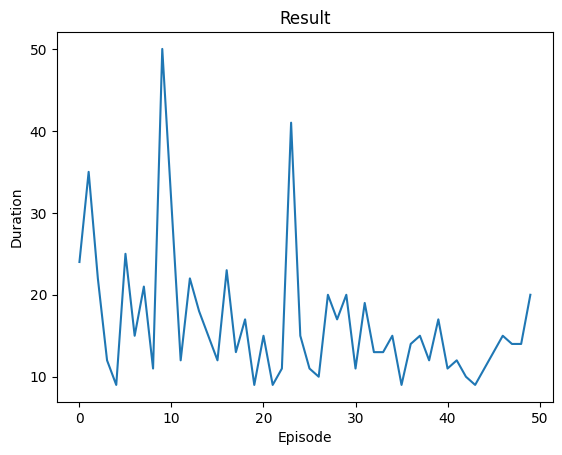

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()